# 2nd-order acoustic horizontal boundary

In this notebook, I will outline the process of implementing a horizontal immersed boundary in Devito using Schism. The boundary is located half a grid increment above index 50. On this surface, we will impose an acoustic free-surface boundary condition.

Note that for the time being, the Devito branch `deriv-subs` is required for Schism to function.

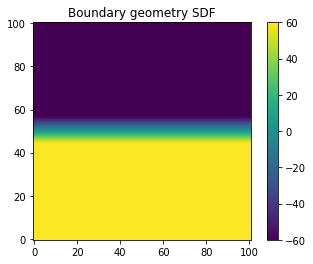

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the flat 2D sdf
sdf = read_sdf('horizontal', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

With our signed distance function as a Devito `Function`, we construct a BoundaryGeometry object.

In [2]:
from schism import BoundaryGeometry

bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


This object uses the sdf to calculate boundary locations, normals, and distance to the boundary from each point. It also identifies the interior region and grid points which are boundary-adjacent.

Next we need to define a `TimeFunction` for pressure.

In [3]:
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=grid, space_order=s_o, time_order=2)

With this we can define boundary conditions to be imposed on the surface. We do this by creating a list of equalities to hold on the surface and passing those to a BoundaryConditions object.

In [4]:
from schism import BoundaryConditions

bc_list = [dv.Eq(p, 0),  # Zero pressure on free surface
           dv.Eq(p.dx2+p.dy2, 0),  # Zero laplacian
           dv.Eq(p.dx4 + 2*p.dx2dy2 + p.dy4, 0)]  # Zero biharmonic

bcs = BoundaryConditions(bc_list)

In the case of the acoustic free surface for pressure, pressure is set to zero. By substituting this into the equation, we can obtain higher-order boundary conditions in the form of the laplacian of pressure, the biharmonic, and so forth. Equalities are supplied as simple Devito `Eq`. Under the hood, `BoundaryConditions` parses and sorts the expressions supplied.

With this, we can assemble our `Boundary`

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

To get the substitution for a derivative expression, one passes a tuple of derivative objects to get modified stencils for to `Boundary.substitutions()`. In the case of a horizontal boundary with the acoustic free surface, we will need to substitute the `p.dx2` derivative stencil.

In [6]:
deriv = (p.dy2,)
subs = boundary.substitutions(deriv)

This yields a dictionary containing the modified stencil expressions, keyed with the derivatives that they replace. We can then use this to form the wave equation.

Before we do this however, we will set up a sponge layer around the edges of the domain.

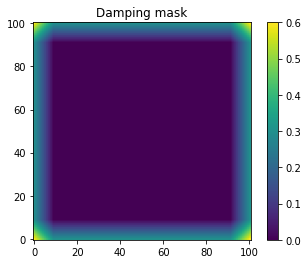

In [7]:
import numpy as np

damp = dv.Function(name='damp', grid=grid)

# Number of boundary layers
nbl = 10
taper = np.linspace(0, 0.3, nbl)

# Add the taper to the function's data
damp.data[:10] += taper[::-1, np.newaxis]
damp.data[-10:] += taper[:, np.newaxis]
damp.data[:, :10] += taper[np.newaxis, ::-1]
damp.data[:, -10:] += taper[np.newaxis, :]

plt.imshow(damp.data.T, origin='lower')
plt.title("Damping mask")
plt.colorbar()
plt.show()

We also need to specify a source term

In [8]:
from examples.seismic import TimeAxis, RickerSource

c = 1

t0 = 0.  # Simulation starts a t=0
tn = 550.  # Simulation last 0.55 seconds (550 ms)
dt = 0.5*10/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions
src.coordinates.data[0, :] = np.array(grid.extent) * .5
src.coordinates.data[0, -1] = 250.  # 250m above bottom

Now we can specify our wave equation with damping terms.

In [9]:
# Check with normal stencils first
eq = dv.Eq(p.forward, 2*p-p.backward+dt**2*c**2*(p.dx2+subs[p.dy2])+damp*p.dt)

Then we can create the source injection term.

In [10]:
src_term = src.inject(field=p.forward, expr=c*src*dt**2)

We can now form our operator and run it.

In [11]:
from devito import Operator

op = Operator([eq] + src_term)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.009056000000000007, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=8e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

And finally plot the result.

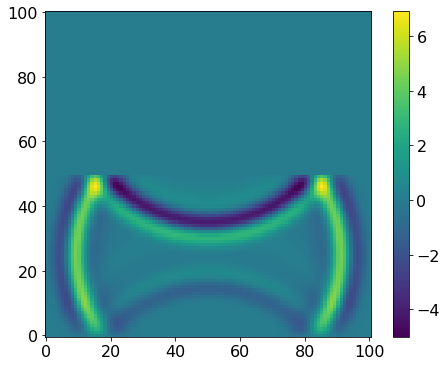

In [12]:
plt.imshow(p.data[1].T, origin='lower')
plt.colorbar()
plt.show()

We can see that the reflected geometry here is as expected.